In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

- 0: hardcore
- 1: lg
- 2: poisson

Each montecarlo: small disturbance
which is better, all samples or just the median.


2 types of files:
- ending in .nc
- ending in _median.nc

In [2]:
jfunc_med = xr.load_dataset("./data/jfunction_data_med.nc")
jfunc_med

<xarray.Dataset>
Dimensions:                 (Radius: 180, Monte Carlo Simulation: 9895,
                             class: 3, y: 1)
Coordinates:
  * Radius                  (Radius) float64 0.0 0.01676 0.03352 ... 2.983 3.0
  * Monte Carlo Simulation  (Monte Carlo Simulation) float64 1.0 ... 9.895e+03
  * class                   (class) int64 0 1 2
Dimensions without coordinates: y
Data variables:
    v                       (class, Monte Carlo Simulation, y, Radius) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.3 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    contact:      Niklas.luther@zeu.uni-giessen.de
    history:      Wed Sep 18 15:48:58 2024: cdo mermean Process=hardcore_INTE...
    CDO:          Climate Data Operators version 2.0.3 (https://mpimet.mpg.de...

In [29]:
up_lim = 1.05
low_lim = 0.95
perc = 0.80

print(np.all(jfunc_med.v[:, :, :, 1:] < 0.9, axis=3).shape)
print((np.count_nonzero(jfunc_med.v[:, :, :, 1:] > 1.1, axis=3)/len(jfunc_med.Radius)).shape)
jfunc_med = jfunc_med.assign(above_1 = (("class", "Monte Carlo Simulation", "y"), np.count_nonzero(jfunc_med.v[:, :, :, 1:] > up_lim, axis=3)/len(jfunc_med.Radius) > perc))
jfunc_med = jfunc_med.assign(below_1 = (("class", "Monte Carlo Simulation", "y"), np.count_nonzero(jfunc_med.v[:, :, :, 1:] < low_lim, axis=3)/len(jfunc_med.Radius) > perc))

jfunc_med.to_netcdf("data/jfunction_data_med_flagged.nc")
jfunc_med

(3, 9895, 1)
(3, 9895, 1)


<xarray.Dataset>
Dimensions:                 (Radius: 180, Monte Carlo Simulation: 9895,
                             class: 3, y: 1)
Coordinates:
  * Radius                  (Radius) float64 0.0 0.01676 0.03352 ... 2.983 3.0
  * Monte Carlo Simulation  (Monte Carlo Simulation) float64 1.0 ... 9.895e+03
  * class                   (class) int64 0 1 2
Dimensions without coordinates: y
Data variables:
    v                       (class, Monte Carlo Simulation, y, Radius) float32 ...
    above_1                 (class, Monte Carlo Simulation, y) bool True ... ...
    below_1                 (class, Monte Carlo Simulation, y) bool False ......
Attributes:
    CDI:          Climate Data Interface version 2.0.3 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    contact:      Niklas.luther@zeu.uni-giessen.de
    history:      Wed Sep 18 15:48:58 2024: cdo mermean Process=hardcore_INTE...
    CDO:          Climate Data Operators version 2.0.3 (https://mpimet.mpg.de...

## Remove after cleaning

In [30]:
X_raw = jfunc_med.v.to_numpy()
X_raw_0 = X_raw[0, ~np.any(np.isnan(X_raw[0]), axis=(1,2))]
X_raw_1 = X_raw[1, ~np.any(np.isnan(X_raw[1]), axis=(1,2))]
X_raw_2 = X_raw[2, ~np.any(np.isnan(X_raw[2]), axis=(1,2))]
X = np.concatenate([X_raw_0, X_raw_1, X_raw_2])
X = X.transpose((0,2,1))
display(X.shape)

above_raw = jfunc_med.above_1.to_numpy()
above_raw_0 = above_raw[0, ~np.any(np.isnan(X_raw[0]), axis=(1,2))]
above_raw_1 = above_raw[1, ~np.any(np.isnan(X_raw[1]), axis=(1,2))]
above_raw_2 = above_raw[2, ~np.any(np.isnan(X_raw[2]), axis=(1,2))]
above = np.concatenate([above_raw_0, above_raw_1, above_raw_2])
display(above.shape)

below_raw = jfunc_med.below_1.to_numpy()
below_raw_0 = below_raw[0, ~np.any(np.isnan(X_raw[0]), axis=(1,2))]
below_raw_1 = below_raw[1, ~np.any(np.isnan(X_raw[1]), axis=(1,2))]
below_raw_2 = below_raw[2, ~np.any(np.isnan(X_raw[2]), axis=(1,2))]
below = np.concatenate([below_raw_0, below_raw_1, below_raw_2])
display(below.shape)

y = np.concatenate([np.zeros(X_raw_0.shape[0], dtype=int), np.ones(X_raw_1.shape[0], dtype=int), np.full(X_raw_2.shape[0], 2)]).reshape((-1, 1))
X.shape, y.shape

(23140, 180, 1)

(23140, 1)

(23140, 1)

((23140, 180, 1), (23140, 1))

In [31]:
print(np.count_nonzero((y==0) & above), np.count_nonzero((y==1) & above), np.count_nonzero((y==2) & above))
print(np.count_nonzero((y==0) & below), np.count_nonzero((y==1) & below), np.count_nonzero((y==2) & below))
print(np.count_nonzero((y==0) & ~(below | above)), np.count_nonzero((y==1) & ~(below | above)), np.count_nonzero((y==2) & ~(below | above)))
print(np.count_nonzero(y==0), np.count_nonzero(y==1), np.count_nonzero(y==2))

7883 5 444
0 4703 388
0 654 9063
7883 5362 9895


In [32]:
simple_filter_matrix = np.zeros((3,3), dtype=int)
simple_filter_matrix[0] = np.count_nonzero((y==0) & above), np.count_nonzero((y==1) & above), np.count_nonzero((y==2) & above)
simple_filter_matrix[1] = np.count_nonzero((y==0) & below), np.count_nonzero((y==1) & below), np.count_nonzero((y==2) & below)
simple_filter_matrix[2] = np.count_nonzero((y==0) & ~(below | above)), np.count_nonzero((y==1) & ~(below | above)), np.count_nonzero((y==2) & ~(below | above))
simple_filter_matrix

array([[7883,    5,  444],
       [   0, 4703,  388],
       [   0,  654, 9063]])

In [33]:
incorrect_count = pd.DataFrame(simple_filter_matrix, columns=["hardcore", "lg", "poisson"])
incorrect_count[" "] = "All above 1", "All below 1", "Not all avobe or below 1"
incorrect_count[[" ", "hardcore", "lg", "poisson"]]

,,hardcore,lg,poisson
0,All above 1,7883,5,444
1,All below 1,0,4703,388
2,Not all avobe or below 1,0,654,9063


/home/simul6/anaconda3/envs/clint_ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/simul6/anaconda3/envs/clint_ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/simul6/anaconda3/envs/clint_ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


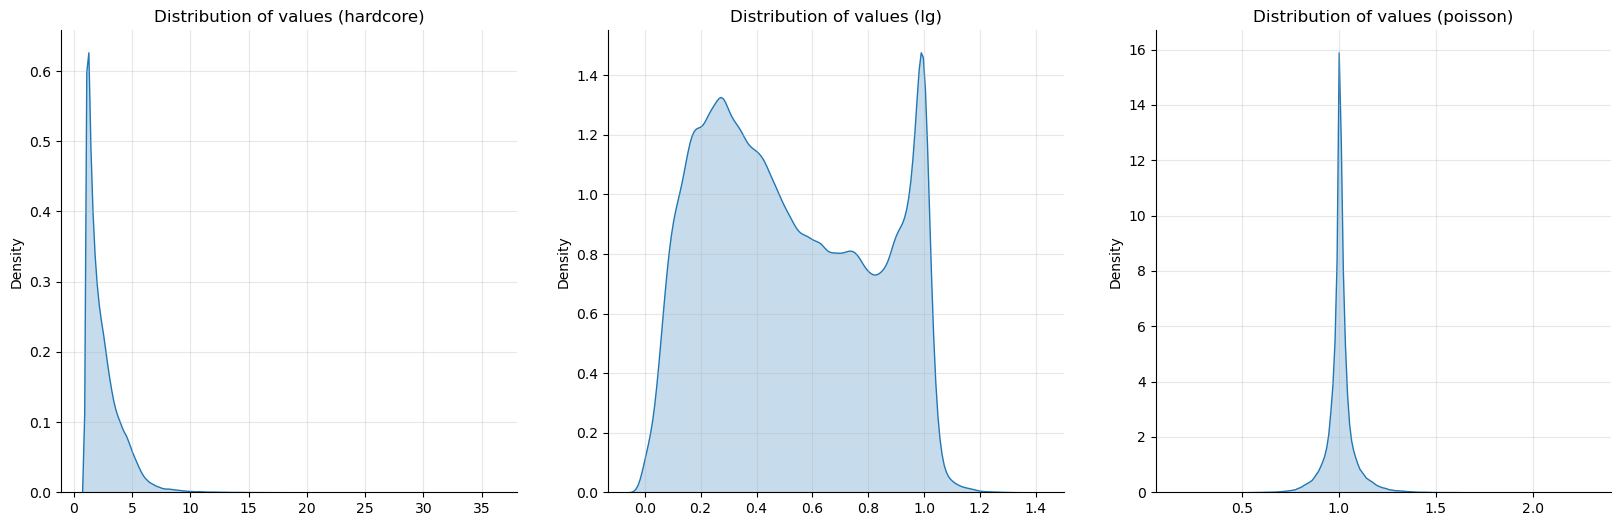

In [34]:
fig, ax = plt.subplots(1,3,figsize=(20,6))
for i in range(3):
    sns.kdeplot(X[y.flatten()==i].flatten(), ax=ax[i], fill=True)
    ax[i].grid(alpha=0.3)
    ax[i].set(title=f"Distribution of values ({['hardcore', 'lg', 'poisson'][i]})")
sns.despine()
plt.show()

[(180, 444), (180, 388), (180, 9063)]


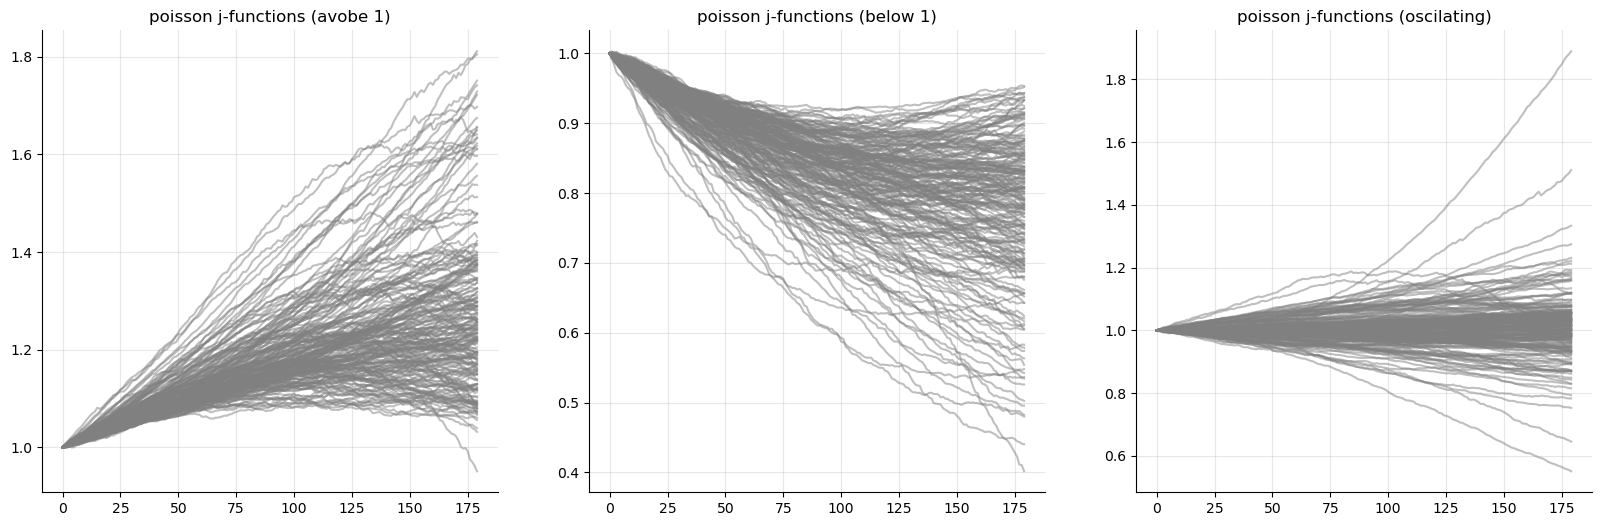

In [35]:
Xa2 = X[((y==2) & above).flatten()].squeeze().T
Xb2 = X[((y==2) & below).flatten()].squeeze().T
Xn2 = X[((y==2) & ~(below | above)).flatten()].squeeze().T
X2 = [Xa2, Xb2, Xn2]
print([i.shape for i in X2])

n_samples = 200
fig, ax = plt.subplots(1,3,figsize=(20,6))
for i in range(3):
    idx = np.random.permutation(X2[i].shape[1])[:n_samples]
    ax[i].plot(X2[i][:, idx], alpha=0.5, color="gray")
    ax[i].grid(alpha=0.3)
    ax[i].set(title=f"poisson j-functions ({['avobe 1', 'below 1', 'oscilating'][i]})")
sns.despine()
plt.show()

In [36]:
np.count_nonzero((y==1) & below)

4703

In [38]:
filter_mask = (((y!=0) & above) | ((y!=1) & below) | ((y!=2) & ~(below | above))).squeeze()
print(X[~filter_mask].shape)
print(y[~filter_mask].shape)

(21649, 180, 1)
(21649, 1)


In [39]:
np.save("./data/jfunction_data_med_pred", X)
np.save("./data/jfunction_data_med_target", y)
np.save("./data/jfunction_data_med_filter", ~filter_mask)